In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy
import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt

import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import spatial_weights
import timeseries
import general_io as gio

In [2]:
%matplotlib inline

# Mass conservation

The first critical comparison related to mass conservation. In other words, we need to compare the water flux into sea water (wfo; time/lat/lon) against the global sea water mass (masso; time). It is also useful to compare these against the global mean sea water salinity (soga; time).

To be more specific, the comparable quantities are the cumulative wfo, sea water mass anomaly and inferred change in sea water mass from soga.

*Assumption: The only way the mass of the global ocean can change is via water flux into sea water.*

*Assumption: The amount of salt in the ocean is fixed, so any change in mass should be reflected in a corresponding change in global mean salinity.* 

In [3]:
def process_masso(model):
    """Process sea water mass data"""
    
    file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/masso/latest/masso_*.nc' %(model)
    masso_files = glob.glob(file_pattern)
    
    if masso_files:
        masso_cube, history = gio.combine_files(masso_files, 'sea_water_mass')
        masso_cube = timeseries.convert_to_annual(masso_cube)
        masso_anomaly = masso_cube.data - masso_cube.data[0]
    else:
        masso_cube = None
        masso_anomaly = None
        
    return masso_cube, masso_anomaly

### Salinity

How are soga ($S$) and change in global ocean mass ($\Delta M$) related?

$\Delta M = -M_{globe}(1 - \frac{S_{orig}}{S_{new}})$

where $M_{globe}$ is the mass of the global ocean. 

(This assumes that the total ocean salt content is constant in the CMIP5 models.)

In [4]:
def inferred_wfo(s_orig, s_new, m_globe=None):
    """Calculate the inferred cumulative global total wfo for a given change in soga.
    
    Inputs are numpy arrays.
    
    """
    
    if not numpy.any(m_globe):
        v=1.35e18
        p = 1027  # kg/m3; average density of global ocean - could calculate from rhopoto data
        m_globe = v * p
    else:
        assert m_globe.shape == s_orig.shape == s_new.shape
    
    delta_m = -1 * m_globe * (1 - (s_orig / s_new))    
    
    return delta_m

In [5]:
v = 1.35e18  # m3; volume of global ocean - could calculate from volcello data
p = 1027  # kg/m3
m_globe = v * p

In [6]:
(0.03 * m_globe) / (m_globe -4.472419354838706e+19)

0.031

In [7]:
def process_soga(model, m_globe=None):
    """Process global mean sea water salinity control data"""
    
    file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/soga/latest/soga_*.nc' %(model)
    soga_files = glob.glob(file_pattern)
    
    if soga_files:
        soga_cube, history = gio.combine_files(soga_files, 'sea_water_salinity')
        soga_cube = gio.salinity_unit_check(soga_cube)
        soga_cube = timeseries.convert_to_annual(soga_cube)

        s_orig = numpy.ones(soga_cube.data.shape[0]) * soga_cube.data[0]
        wfo = numpy.fromiter(map(inferred_wfo, s_orig, soga_cube.data, m_globe.data), float)
    else:
        soga_cube = None
        wfo = None
        
    return soga_cube, wfo

### Water flux into sea water

This variable represents the net freshwater flux at the ocean surface. In other words, it is ("probably" - direct quote from CMIP5 docs) the sum of:
* `pr`: rainfall flux
* `prsn`: snowfall flux
* `evs`: water evaporation flux
* `friver`: water flux into seawater from rivers
* `ficeberg`: water flux into seawater from ice bergs
* `fsitherm`: water flux into sea water due to sea ice thermodynamics

All of these are second priority variables (as is `wfo`) except for `fsitherm` (first priority), which means if `wfo` isn't archived there's not much chance all the components are. Also, most models that do archive `wfo` don't archive all the components, but you could probably get a good picture just from `pr`, `evs` and `friver`.

I'm assuming that means no models have any runoff due to glacier or ice cap melt, or perhaps those are included in river runoff?

It's worth noting how freshwater fluxes are represented differently across models, with some models converting the freshwater flux to a virtual salt flux (so that the volume of the ocean stays the same). [This paper](https://www.sciencedirect.com/science/article/pii/S2095927317300932) gives a good overview.

In [8]:
def process_wfo(model):
    """Process water flux into sea water data
    
    The units need to be converted from kg m-2 s-1 to kg in order
    to be able to work effectively with the salinity data (which is g/kg)
    
    """
    
    wfo_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/wfo/latest/wfo_*.nc' %(model)
    wfo_files = glob.glob(wfo_pattern)
    
    area_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/areacello/latest/areacello_*.nc' %(model)
    area_file = glob.glob(area_pattern)
    
    if wfo_files and area_file:
        wfo_cube, history = gio.combine_files(wfo_files, 'water_flux_into_sea_water')
        wfo_cube = timeseries.convert_to_annual(wfo_cube)

        area_cube = iris.load_cube(area_file)
        area_array = uconv.broadcast_array(area_cube.data, [1, area_cube.ndim], wfo_cube.shape)

        units = str(wfo_cube.units)
        assert units == 'kg m-2 s-1'
        wfo_cube.units = units.replace('m-2', '')
        wfo_cube.data = wfo_cube.data * area_array

        # Calculate the global sum
        wfo_cube = wfo_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=None)
        wfo_cube.remove_coord('latitude')
        wfo_cube.remove_coord('longitude')

        # Remove the s-1
        assert 'days' in str(wfo_cube.coord('time').units)
        time_span_days = wfo_cube.coord('time').bounds[:, 1] - wfo_cube.coord('time').bounds[:, 0]
        time_span_seconds = time_span_days * 60 * 60 * 24
        wfo_cube.data = wfo_cube.data * time_span_seconds
        units = str(wfo_cube.units)
        wfo_cube.units = units.replace('s-1', '')

        wfo_cumsum = numpy.cumsum(wfo_cube.data)
    
    else:
        wfo_cube = None
        wfo_cumsum = None

    return wfo_cube, wfo_cumsum

[In the CNRM-CM5 model wfo variable is positive upwards](http://www.umr-cnrm.fr/cmip5/spip.php?article24). I wonder if that's the case for other models? (TODO: Look at spatial fields to determine this.)

In [25]:
def plot_wfo_map(model, quantity='climatology'):
    """Plot wfo spatial map.
    
    Useful to check that positive is down/into ocean."""

    assert quantity in ['climatology', 'cumulative_anomaly']
    
    wfo_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/wfo/latest/wfo_*.nc' %(model)
    wfo_files = glob.glob(wfo_pattern)
    
    wfo_cube, history = gio.combine_files(wfo_files, 'water_flux_into_sea_water')

    if quantity == 'climatology':
        plot_cube = wfo_cube.collapsed('time', iris.analysis.MEAN)
        vmin = -0.0003
        vmax = 0.0003
    else:
        plot_cube = wfo_cube.copy()
        plot_cube.data = plot_cube.data - wfo_cube[0, ::].data
        plot_cube = plot_cube.collapsed('time', iris.analysis.SUM)        
        vmin = -3
        vmax = 3
    
    iplt.pcolormesh(plot_cube, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.title(quantity)
    cb = plt.colorbar()
    cb.set_label(str(plot_cube.units))
    
    plt.show()

# Sea level

The second comparison to make is the global sea water volume (volo; time) versus global average sea level change (zosga). We can use areacello data to relate the change in volo to zosga.

*Assumption: The only way the global average sea level can change is if the volume of the global ocean changes.*

In [10]:
def process_volo(model):
    """Process sea water volume"""
    
    volo_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/volo/latest/volo_*.nc' %(model)
    volo_files = glob.glob(volo_file_pattern)
    
    if volo_files:
        volo_cube, history = gio.combine_files(volo_files, 'sea_water_volume')
        volo_cube = timeseries.convert_to_annual(volo_cube)
        
        areacello_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/areacello/latest/areacello_*.nc' %(model)
        areacello_file = glob.glob(areacello_file_pattern)
        
        if areacello_file:
            areacello_cube = iris.load_cube(areacello_file[0])
            volo_anomaly = volo_cube.data - volo_cube.data[0]
            inferred_zosga = volo_anomaly / areacello_cube.data.sum()
        else:
            inferred_zosga = None

    else:
        volo_cube = None
        
    return volo_cube, inferred_zosga
    
    
def process_zosga(model, variable):
    """Process global average change in sea level."""
    
    names = {'zosga': 'global_average_sea_level_change',
             'zostoga': 'global_average_thermosteric_sea_level_change',
             'zossga': 'global_average_steric_sea_level_change'}
    
    assert variable in names.keys()
    
    zosga_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/%s/latest/%s_*.nc' %(model, variable, variable)
    zosga_files = glob.glob(zosga_file_pattern)
    #zosga_files.sort()
    #zosga_files = zosga_files[1:]
    
    if zosga_files:
        zosga_cube, history = gio.combine_files(zosga_files, names[variable])
        zosga_cube = timeseries.convert_to_annual(zosga_cube)
        zosga_cube.data = zosga_cube.data - zosga_cube.data[0]
    else:
        zosga_cube = None
    
    return zosga_cube

# Other variables

In [11]:
def process_thetaoga(model):
    """Process global average sea water potential temperature data"""
        
    thetaoga_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/thetaoga/latest/thetaoga_*.nc' %(model)
    thetaoga_files = glob.glob(thetaoga_file_pattern)
    #thetaoga_files.sort()
    #thetaoga_files = thetaoga_files[1:]
    
    if thetaoga_files:
        thetaoga_cube, history = gio.combine_files(thetaoga_files, 'sea_water_potential_temperature')
        thetaoga_cube = timeseries.convert_to_annual(thetaoga_cube)
        thetaoga_cube.data = thetaoga_cube.data - thetaoga_cube.data[0]
    else:
        thetaoga_cube = None
    
    return thetaoga_cube

I'm going to need to calculate the global mean rhopoto offline because it will probably cause memory errors.

# Plot control data

In [12]:
def masso_from_zosga(model, zosga, zossga):
    """Infer masso from zosga and zossga.
    
    Ocean density constant at 1027 kg/m3
    
    """
    
    if zosga and zossga:
        areacello_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/areacello/latest/areacello_*.nc' %(model)
        areacello_file = glob.glob(areacello_file_pattern)
        areacello_cube = iris.load_cube(areacello_file[0])
        
        eustatic = zosga.data - zossga.data
        inferred_masso = eustatic * areacello_cube.data.sum() * 1027
    else:
        inferred_masso = None
        
    return inferred_masso

In [13]:
def masso_from_volo(volo, anomaly=False):
    """Infer masso from volo.
    
    Ocean density constant at 1027 kg/m3
    
    """
    
    inferred_masso = volo.copy()
    inferred_masso.data = inferred_masso.data * 1027
    if anomaly:
        inferred_masso.data = inferred_masso.data - inferred_masso.data[0]
        
    return inferred_masso.data


def plot_water_conservation(model, raw_data=False):
    """Plot key water conservation variables."""
    
    masso, masso_anomaly = process_masso(model)
    wfo, cumulative_wfo = process_wfo(model)
    soga, cumulative_wfo_inferred_from_soga = process_soga(model, m_globe=masso)
    volo, zosga_inferred_from_volo = process_volo(model)
    zosga = process_zosga(model, 'zosga')
    zossga = process_zosga(model, 'zossga')
    zostoga = process_zosga(model, 'zostoga')
    masso_inferred_from_zosga = masso_from_zosga(model, zosga, zossga)
    
    if raw_data:
        fig = plt.figure(figsize=[16, 15])
        ax1 = fig.add_subplot(3, 2, 1)
        ax2 = fig.add_subplot(3, 2, 2)
        ax3 = fig.add_subplot(3, 2, 3)
        ax4 = fig.add_subplot(3, 2, 4)
        ax5 = fig.add_subplot(3, 2, 5)

        if numpy.any(masso):
            ax1.plot(masso.data, color='green')
            ax1.set_title(masso.long_name)
            ax1.set_xlabel('year')
            ax1.set_ylabel(masso.units)
            ax1.ticklabel_format(useOffset=False)
        
        if volo:
            ax2.plot(volo.data, color='red')
            ax2.set_title(volo.long_name)
            ax2.set_xlabel('year')
            ax2.set_ylabel(volo.units)
            ax2.ticklabel_format(useOffset=False)
        
        if wfo:
            ax3.plot(wfo.data, color='blue')
            ax3.set_title(wfo.long_name)
            ax3.set_xlabel('year')
            ax3.set_ylabel(wfo.units)
            ax3.ticklabel_format(useOffset=False)

        if zosga:
            ax4.plot(zosga.data, color='purple')
            if zossga:
                ax4.plot(zossga.data, color='purple', linestyle=':', label='change in steric sea level')
            if zostoga:
                ax4.plot(zostoga.data, color='purple', linestyle='--', label='change in thermosteric sea level')
            ax4.legend()
            ax4.set_title(zosga.long_name)
            ax4.set_xlabel('year')
            ax4.set_ylabel(zosga.units)
            ax4.ticklabel_format(useOffset=False)
            
        if soga:
            ax5.plot(soga.data, color='orange')
            ax5.set_xlabel('year')
            ax5.set_ylabel('salinity (g/kg)')
            ax5.set_title(soga.long_name)
            ax5.ticklabel_format(useOffset=False, style='plain')

    else:

        fig = plt.figure(figsize=[17, 5])
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        if masso:
            ax1.plot(masso_anomaly, color='green', label='ocean mass anomaly (masso)')
        if wfo:
            ax1.plot(cumulative_wfo, color='blue', label='cumulative water flux into ocean (wfo)')
        if soga:
            ax1.plot(cumulative_wfo_inferred_from_soga, color='orange', label='mean salinity anomaly (soga)')
        if zosga and zossga:
            ax1.plot(masso_inferred_from_zosga, color='purple', label='change in eustatic sea level (zosga - zossga)')
        
        ax1.set_title("global ocean mass anomaly")
        ax1.set_xlabel('year')
        ax1.set_ylabel('kg')
        ax1.ticklabel_format(useOffset=False)
        ax1.legend()
        
        if zosga:
            ax2.plot(zosga.data, color='purple', label='global average sea level change (zosga)')
        if zossga:
            ax2.plot(zossga.data, color='purple', linestyle=':', label='change in steric sea level (zossga)')
        if zostoga:
            ax2.plot(zostoga.data, color='purple', linestyle='--', label='change in thermosteric sea level (zostoga)')
        if zosga and zossga:
            ax2.plot(zosga.data - zossga.data, color='purple', linestyle='-.', label='change in eustatic sea level (zosga-zossga)')
        if volo:
            ax2.plot(zosga_inferred_from_volo, color='red' ,label='ocean volume anomaly (volo)')
        ax2.set_title("global mean sea level anomaly")
        ax2.set_xlabel('year')
        ax2.set_ylabel('m')
        ax2.ticklabel_format(useOffset=False)
        ax2.legend()
        
        if masso and volo:
            ax3.plot(masso_anomaly, color='green', label='ocean mass anomaly (masso)')
            masso_anomaly_inferred_from_volo = masso_from_volo(volo, anomaly=True)
            ax3.plot(masso_anomaly_inferred_from_volo, color='red', label='ocean volume anomaly (volo; rho=1027)')
            
            ax3.set_title("global ocean mass anomaly")
            ax3.set_xlabel('year')
            ax3.set_ylabel('kg')
            ax3.ticklabel_format(useOffset=False)
            ax3.legend()
            
    #plt.suptitle(model)
    plt.show()

### ACCESS family

ACCESS1-0: Boussinesq, free surface, freshwater flux

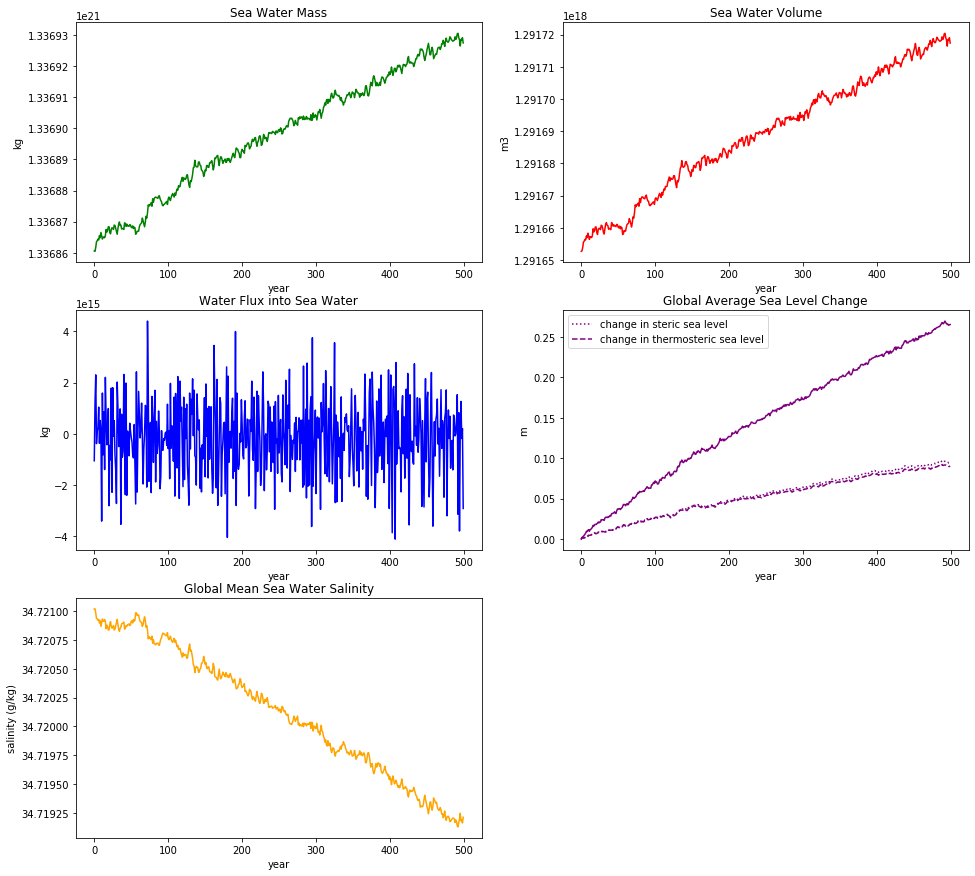

In [15]:
plot_water_conservation('ACCESS1-0', raw_data=True)

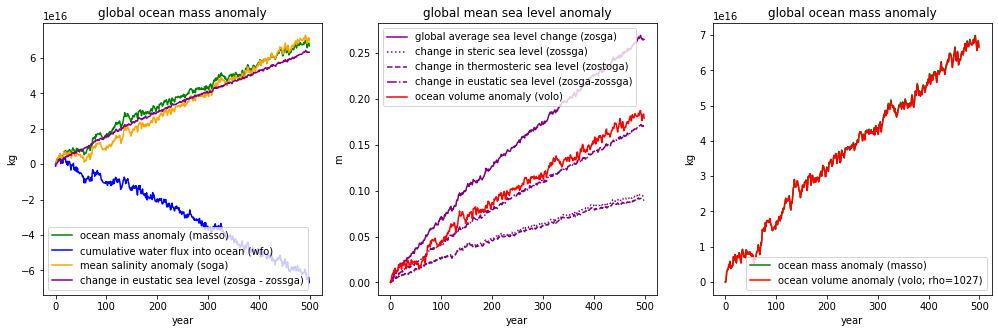

In [40]:
plot_water_conservation('ACCESS1-0')

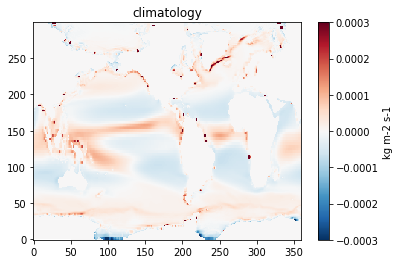

In [26]:
plot_wfo_map('ACCESS1-0', quantity='climatology')

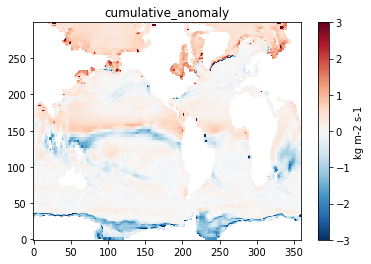

In [27]:
plot_wfo_map('ACCESS1-0', quantity='cumulative_anomaly')

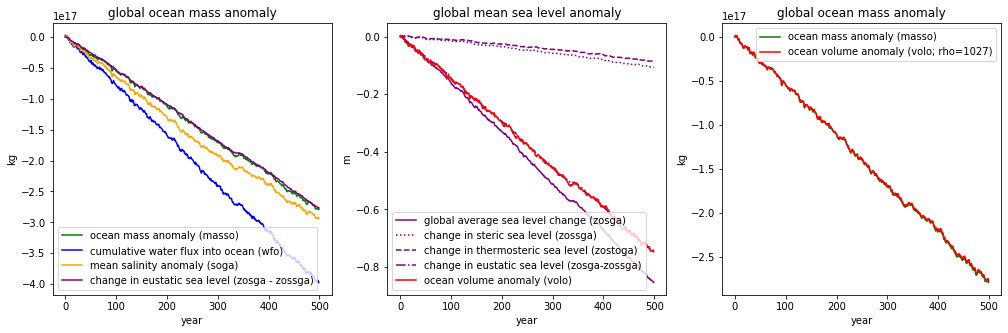

In [42]:
plot_water_conservation('ACCESS1-3')

### CMCC family

(It looks like two of these models have a regid lid ocean model, which means the ocean volume doesn't change and instead of freshwater fluxes at the ocean surface they introduce a virtual salt flux.)

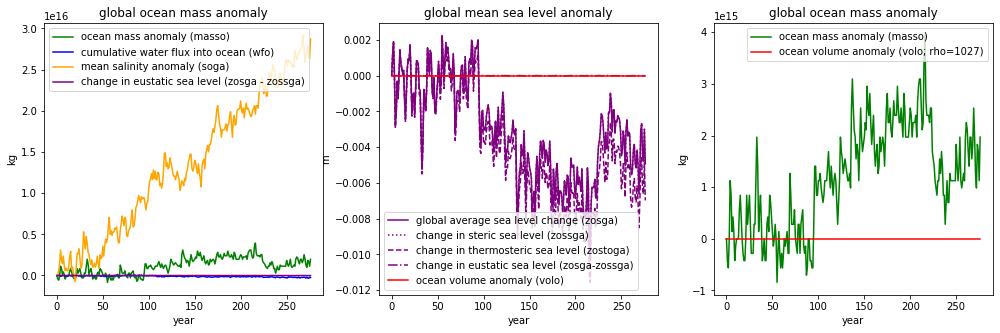

In [43]:
plot_water_conservation('CMCC-CESM')

CMCC-CM: Boussinesq, free surface, freshwater flux

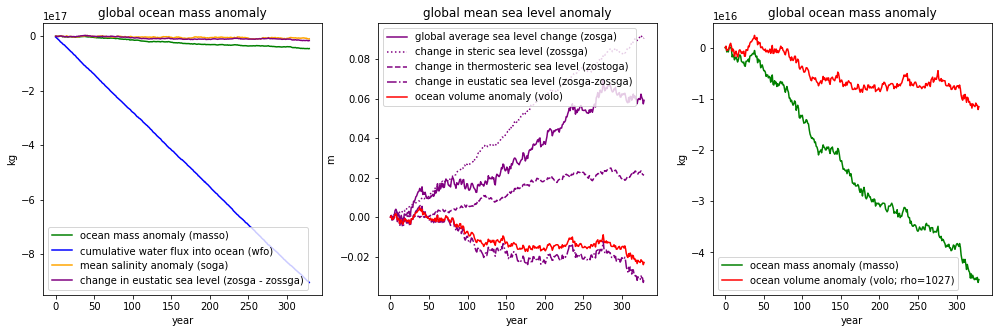

In [44]:
plot_water_conservation('CMCC-CM')

CMCC-CMS: Boussinesq, free surface, freshwater flux

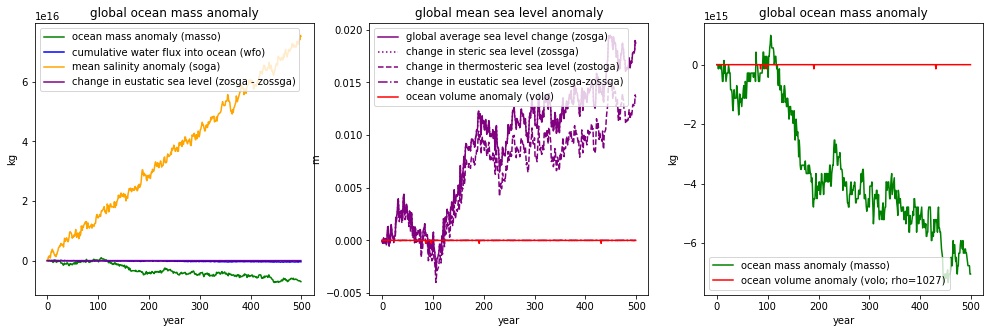

In [45]:
plot_water_conservation('CMCC-CMS')

### GFDL family

GFDL-ESM2M: Boussinesq, free surface, freshwater flux

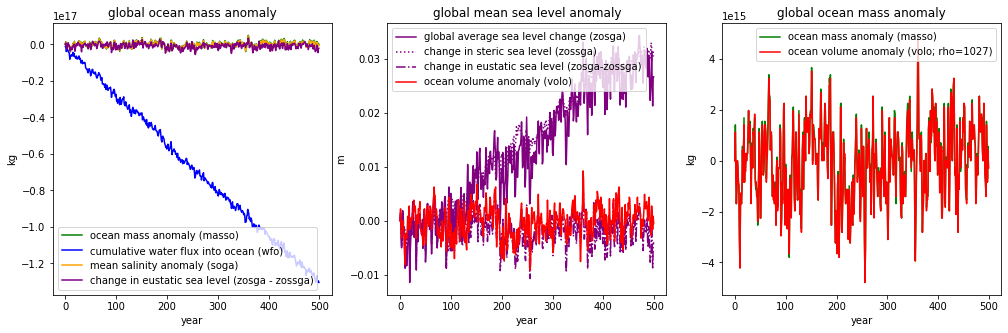

In [46]:
plot_water_conservation('GFDL-ESM2M')

GFDL-ESM2G: Boussinesq, free surface, freshwater flux

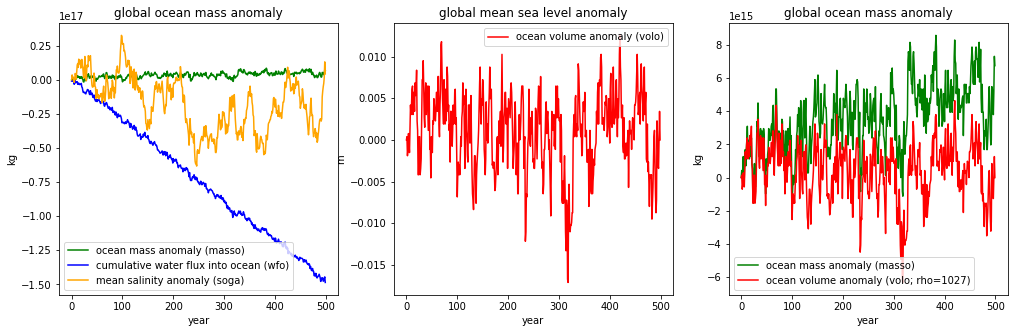

In [24]:
plot_water_conservation('GFDL-ESM2G')

GFDL-CM3: Boussinesq, free surface, freshwater flux

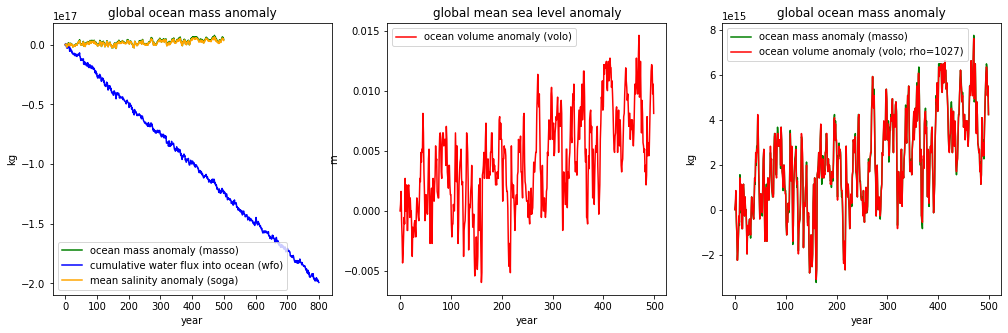

In [25]:
plot_water_conservation('GFDL-CM3')

### IPSL family

IPSL-CM5A-LR: Boussinesq, free surface, freshwater flux

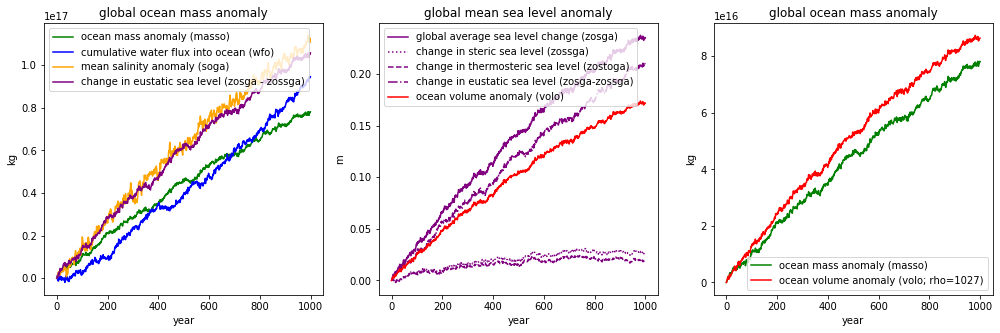

In [47]:
plot_water_conservation('IPSL-CM5A-LR')

IPSL-CM5A-MR: Boussinesq, free surface, freshwater flux

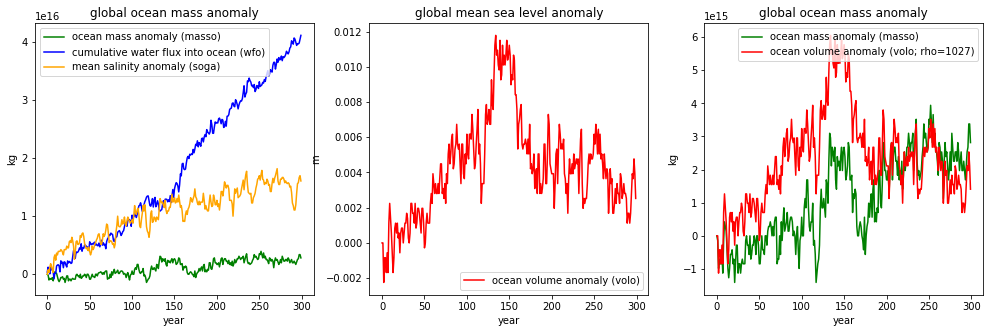

In [27]:
plot_water_conservation('IPSL-CM5A-MR')

IPSL-CM5B-LR: Boussinesq, free surface, freshwater flux

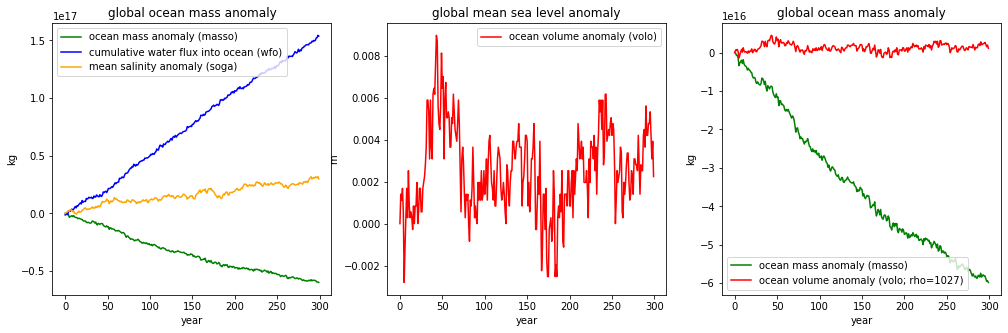

In [28]:
plot_water_conservation('IPSL-CM5B-LR')

### MIROC family

MIROC-ESM: Boussinesq, free surface, freshwater flux

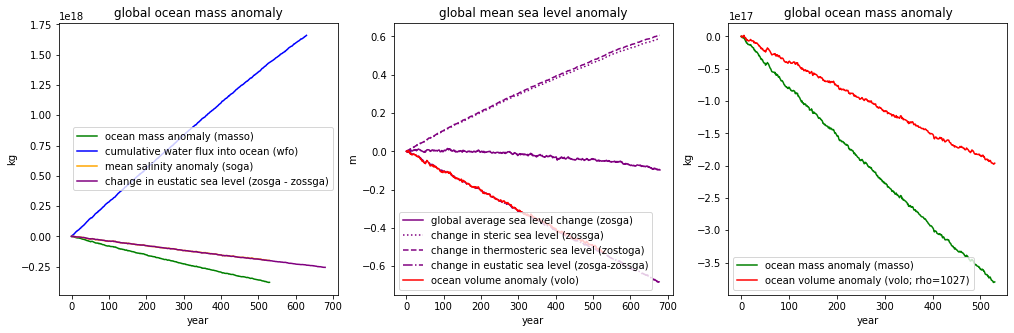

In [48]:
plot_water_conservation('MIROC-ESM')

In [30]:
plot_water_conservation('MIROC-ESM-CHEM')

ConcatenateError: failed to concatenate into a single cube.
  An unexpected problem prevented concatenation.
  Expected only a single cube, found 2.

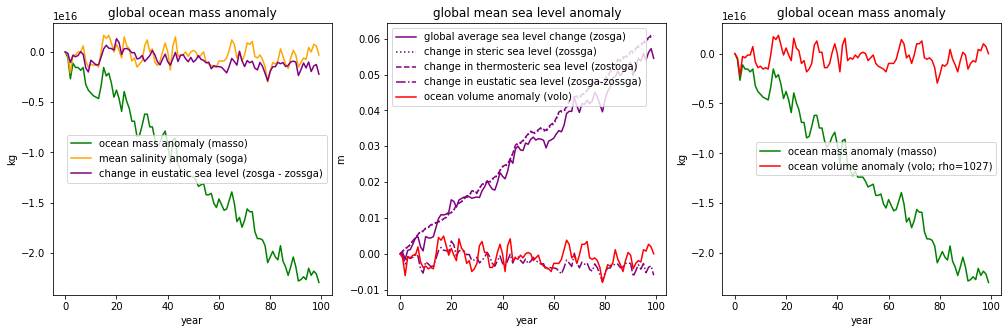

In [49]:
plot_water_conservation('MIROC4h')

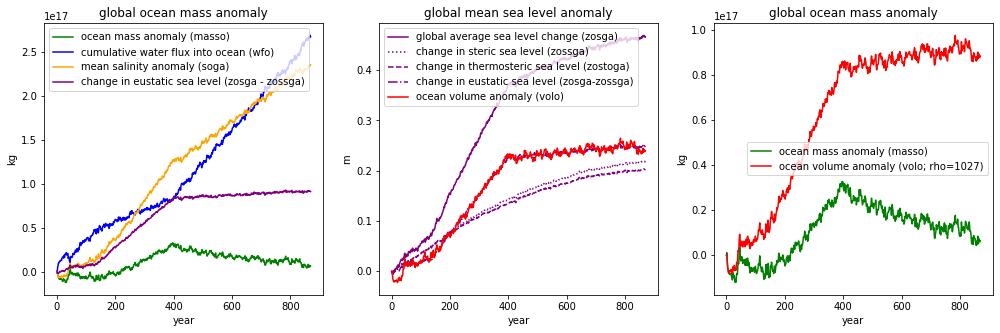

In [50]:
plot_water_conservation('MIROC5')

### MPI family

MPI-ESM-LR: Boussinesq, free surface, freshwater flux

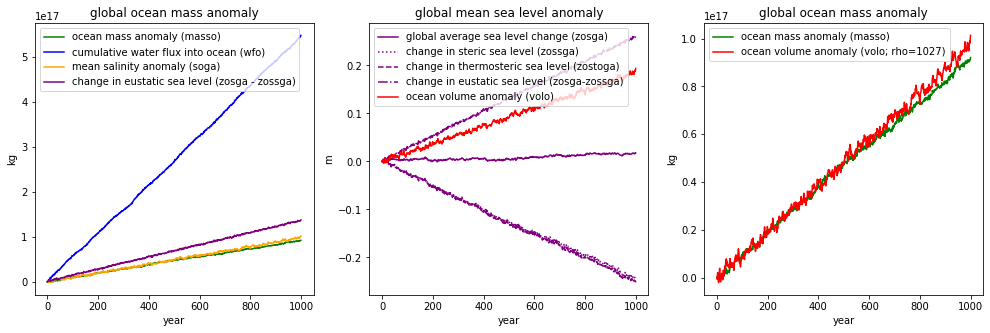

In [51]:
plot_water_conservation('MPI-ESM-LR')

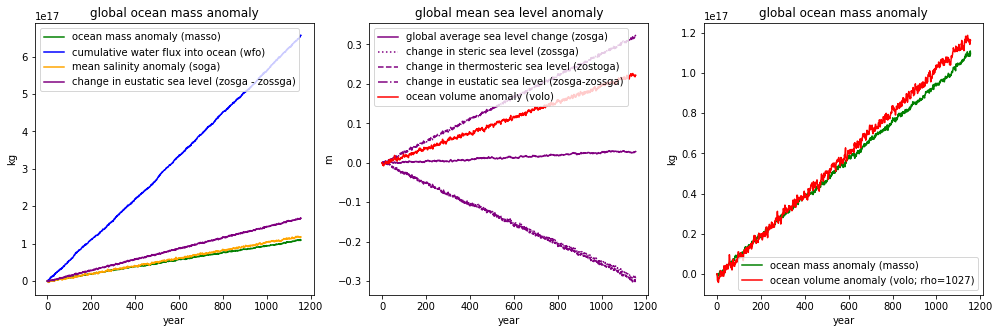

In [52]:
plot_water_conservation('MPI-ESM-P')

### NorESM family

NorESM1-M: non-Boussinesq, free surface, virtual salt flux

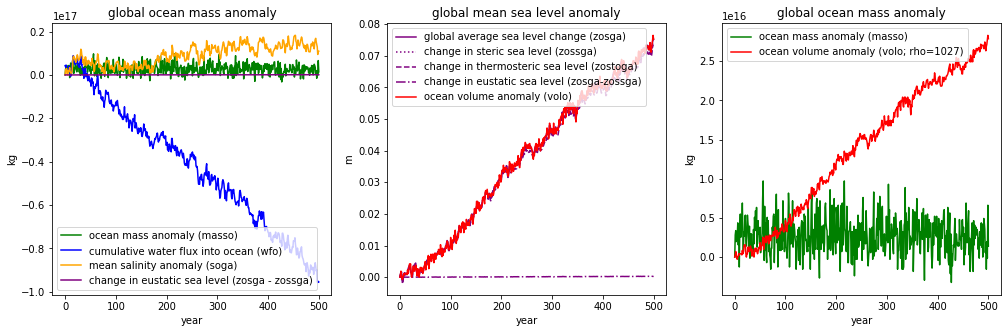

In [53]:
plot_water_conservation('NorESM1-M')

NorESM1-ME: non-Boussinesq, free surface, virtual salt flux

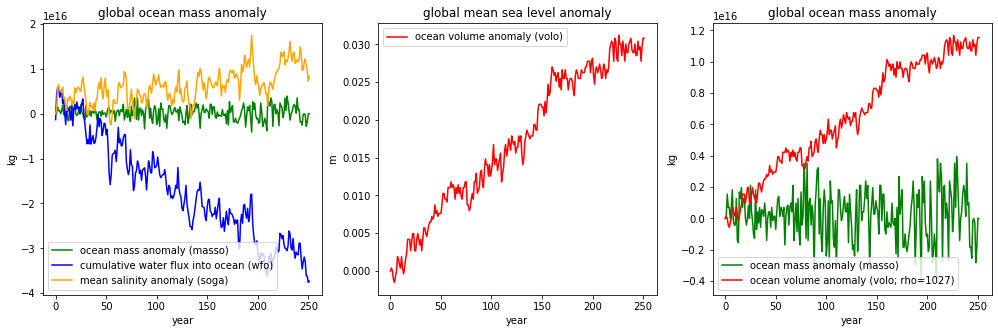

In [36]:
plot_water_conservation('NorESM1-ME')

# dedrifted timeseries

Inputs generated from `~/ocean-analysis/workflows/freshwater_drift.sh`.

In [13]:
def soga_to_wfo(soga_cube, wfo_dummy_cube, ocean_volume):
    """Convert from soga timeseries to wfo cumulative sum"""

    s_orig = numpy.ones(soga_cube.data.shape[0]) * soga_cube.data[0]
    v = numpy.ones(soga_cube.data.shape[0]) * ocean_volume
    wfo_cube = wfo_dummy_cube.copy()
    wfo_cube.data = numpy.fromiter(map(inferred_wfo, s_orig, soga_cube.data, v), float)
    
    return wfo_cube

In [16]:
def plot_drift(model, experiment, ylim=None, volcello_inferred=False):
    """Plot experiment data before and after dedrifting"""

    file_dir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/r1i1p1' %(model, experiment)
    if volcello_inferred:
        volcello_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/fx/ocean/r0i0p0/volcello/latest/volcello-inferred_fx_%s_historical_r0i0p0.nc' %(model, model)
    else:
        volcello_file = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/volcello/latest/volcello_fx_%s_historical_r0i0p0.nc' %(model, model)
    volume_cube = iris.load_cube(volcello_file)
    ocean_volume = volume_cube.data.sum()
    print('ocean volume:', ocean_volume, 'm3')
    
    # wfo data
    wfo_orig_file = '%s/wfo/latest/wfo-sum-hemispheric-metrics_Oyr_%s_%s_r1i1p1_cumsum-all.nc' %(file_dir, model, experiment)
    wfo_dedrifted_file = '%s/wfo/latest/dedrifted/wfo-globe-sum_Oyr_%s_%s_r1i1p1_cumsum-all.nc' %(file_dir, model, experiment)
    
    wfo_orig_cube = iris.load_cube(wfo_orig_file, 'Water Flux into Sea Water globe sum')
    wfo_orig_cube.data = wfo_orig_cube.data - wfo_orig_cube.data[0]
    
    wfo_dedrifted_cube = iris.load_cube(wfo_dedrifted_file, 'Water Flux into Sea Water globe sum')
    wfo_dedrifted_cube.data = wfo_dedrifted_cube.data - wfo_dedrifted_cube.data[0]
    
    # soga data
    soga_orig_file = '%s/soga/latest/soga_Oyr_%s_%s_r1i1p1_all.nc' %(file_dir, model, experiment)
    soga_dedrifted_file = '%s/soga/latest/dedrifted/soga_Oyr_%s_%s_r1i1p1_all.nc' %(file_dir, model, experiment)
    
    soga_orig_cube = iris.load_cube(soga_orig_file, 'sea_water_salinity')
    soga_dedrifted_cube = iris.load_cube(soga_dedrifted_file, 'sea_water_salinity')
    
    inferred_wfo_orig_cube = soga_to_wfo(soga_orig_cube, wfo_orig_cube, ocean_volume)
    inferred_wfo_dedrifted_cube = soga_to_wfo(soga_dedrifted_cube, wfo_dedrifted_cube, ocean_volume)
    
    # Create the plot
        
    iplt.plot(wfo_orig_cube, color='blue', linestyle='--')
    iplt.plot(wfo_dedrifted_cube, color='blue', label='wfo')

    iplt.plot(inferred_wfo_orig_cube, color='orange', linestyle='--')
    iplt.plot(inferred_wfo_dedrifted_cube, color='orange', label='wfo inferred from soga')

    if ylim:
        plt.ylim(ylim)
    
    plt.ylabel(inferred_wfo_orig_cube.units)
    plt.legend()
    plt.title(model + ', ' + experiment)
    plt.show()

ocean volume: 1.3735492558239864e+18 m3


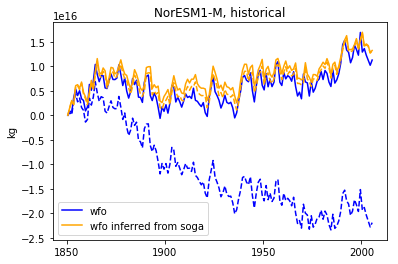

In [19]:
plot_drift('NorESM1-M', 'historical', volcello_inferred=True)

ocean volume: 1.3391147e+18 m3


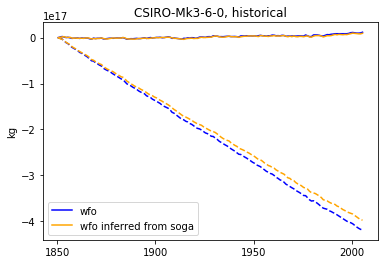

In [20]:
plot_drift('CSIRO-Mk3-6-0', 'historical')

ocean volume: 1.3391147e+18 m3


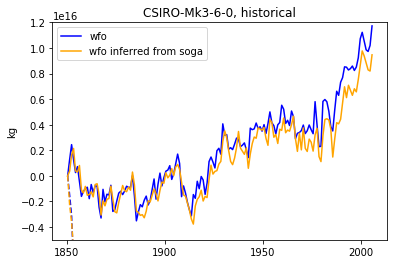

In [21]:
plot_drift('CSIRO-Mk3-6-0', 'historical', ylim=[-0.5e16, 1.2e16])

ocean volume: 1.3391147e+18 m3


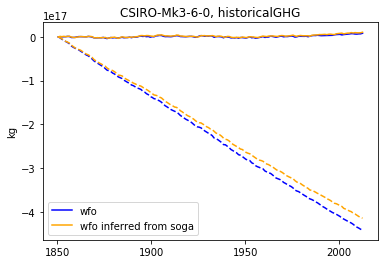

In [22]:
plot_drift('CSIRO-Mk3-6-0', 'historicalGHG')

ocean volume: 1.3391147e+18 m3


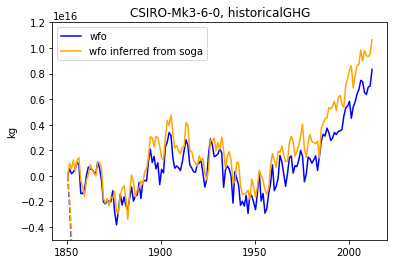

In [23]:
plot_drift('CSIRO-Mk3-6-0', 'historicalGHG', ylim=[-0.5e16, 1.2e16])

ocean volume: 1.3761059837019945e+18 m3


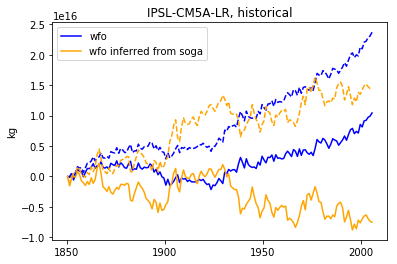

In [25]:
plot_drift('IPSL-CM5A-LR', 'historical', volcello_inferred=True)